,0
index,
2023-08-15 20:21:00,0.0
2023-08-16 01:38:00,0.0
2023-08-16 02:00:00,0.0
2023-08-16 03:38:00,0.0
2023-08-16 05:26:00,0.0
...,...
2023-08-29 08:01:00,0.0
2023-08-29 08:02:00,0.0
2023-08-29 08:03:00,0.0


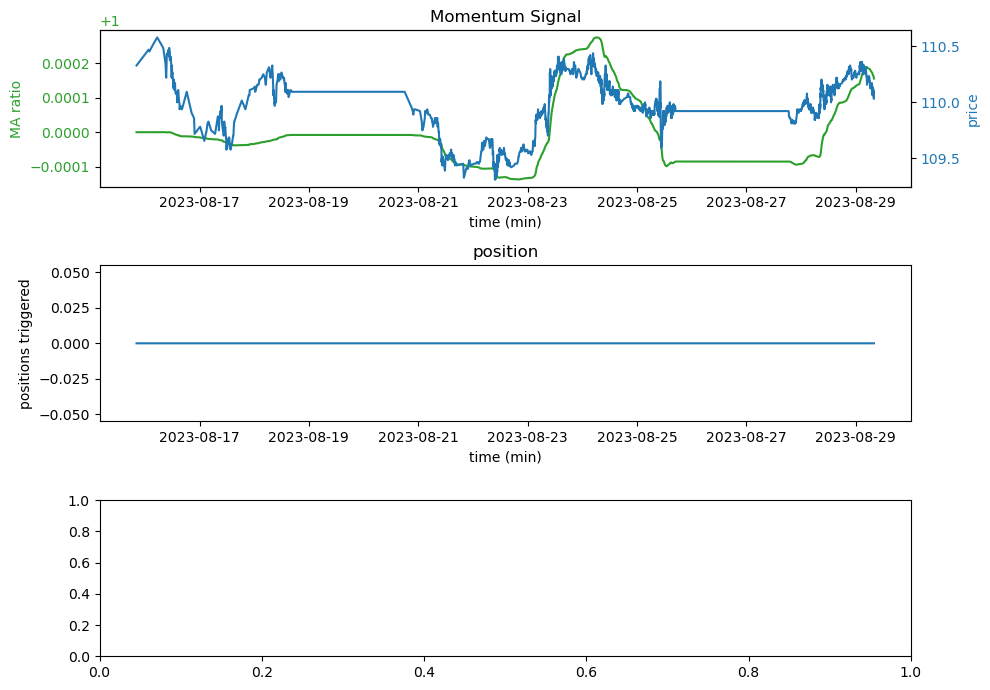

In [4]:
#test for dollar bars later
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xbbg
import scipy
from scipy.interpolate import CubicSpline
from xbbg import blp
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.pyplot import plot
from matplotlib import pyplot as plt
import os
import matplotlib.ticker as plticker
import pandas_datareader as pdr
import datetime
# BDay is business day, not birthday...
from pandas.tseries.offsets import BDay
import numpy as np
import matplotlib.pyplot as plt
tickers = ['TYZ3 Comdty']


#last 10 business days of intraday data
df = pd.DataFrame()

for ticker in tickers:
    for i in range(0,2*5):
        #print(i)
        today = datetime.datetime.today()
        date = today - BDay(i)
        #print(date)


        #lets do outright futures, swap spreads and future spreads
        fut = blp.bdib(ticker=ticker, dt= date , ref='CME', interval=1)
        if fut.columns.nlevels > 1:
            fut.columns = fut.columns.droplevel(0)
        df = df.append(fut)

    df['ticker']= ticker
    df['date']=df.index.strftime("%m/%d/%Y")
    df['time']= df.index.strftime("%H:%M:%S")
    df.sort_index(ascending=True, inplace = True)
    df.index = df.index.tz_localize(None)

    
trades = df[['close','volume']].copy()
trades.reset_index(inplace= True)
trades['index']=pd.to_numeric(trades['index'])#trades['index'].astype(str)



#generate volume bars we only fill a new bar if a set number of futures are traded. 
#This will remove a lot of the asia session futures with low liquitiy
def generate_volumebars(trades, frequency=10):
    times = trades[:,0]
    prices = trades[:,1]
    volumes = trades[:,2]
    ans = np.zeros(shape=(len(prices), 6))
    candle_counter = 0
    vol = 0
    lasti = 0
    for i in range(len(prices)):
        vol += volumes[i]
        if vol >= frequency:
            #print(times[i] )
            #print(ans[candle_counter][0])
            ans[candle_counter][0] = times[i]             # time
            ans[candle_counter][1] = prices[lasti]                     # open
            ans[candle_counter][2] = np.max(prices[lasti:i+1])         # high
            ans[candle_counter][3] = np.min(prices[lasti:i+1])         # low
            ans[candle_counter][4] = prices[i]                         # close
            ans[candle_counter][5] = np.sum(volumes[lasti:i+1])        # volume
            candle_counter += 1
            lasti = i+1
            vol = 0
    return ans[:candle_counter]

#determine trading volume threshold
#lets just use average for now.
#going fwd we can do a 20 day moving average sampled about 50 times a day
threshold = round(trades['volume'].mean(),0)

volume_trades =generate_volumebars(trades.to_numpy(), frequency =threshold)

volume_trades = pd.DataFrame(volume_trades, columns =['index','open','high','low','close','volume'])
volume_trades.set_index('index', inplace = True)

trades.set_index('index', inplace = True)
#convert back to datetime
volume_trades.index = pd.to_datetime(volume_trades.index.astype(np.int64), format ='%Y-%m-%d %H:%M:%S')
trades.index = pd.to_datetime(trades.index, format ='%Y-%m-%d %H:%M:%S')

ma_tuples = (780,960)
holdtime=60

ratio = 0.0003


df = volume_trades[['close']].copy()

df['ewm_short'] = df['close'].ewm(span = ma_tuples[0]).mean()
df['ewm_long'] = df['close'].ewm(span = ma_tuples[1]).mean()
df['ewm_ratio'] = df['ewm_short'] /df['ewm_long'] 
        
longs= df[['ewm_ratio']] > (1+ ratio)
shorts=df[['ewm_ratio']] < (1-ratio)

pos=np.zeros(df[['close']].shape)

for h in range(holdtime-1): # this prevents doubling down of signal 
    #(but will keep extending 1 bar if the signal remains strong) so no hard take profit!
    #moving stop loss ?
    long_lag=longs.shift(h).fillna(False)
    short_lag=shorts.shift(h).fillna(False)
    pos[long_lag]=pos[long_lag]+1
    pos[short_lag]=pos[short_lag]-1
    
pos=pd.DataFrame(pos,index = longs.index)

pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
#print(np.mean(ret))
#print(np.std(ret))
cumret=(np.cumprod(1+ret)-1)
#print("---returns data %s seconds ---" % (time.time() - start_time))
#start_time = time.time()
sharpe = np.sqrt(252)*np.mean(ret)/np.std(ret)
pos=pd.DataFrame(pos)
pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pd.Series(pnl)#/np.sum(np.abs(pos.shift()), axis=1)
cumret=(np.cumprod(1+ret)-1)

#Plots
#fig, ax = plt.subplots(nrows=3,figsize=(10, 10))
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(311)   #first is number of rows, second is number of columns
fig.add_subplot(312)   
fig.add_subplot(313)   
# create all axes we need
ax0 = plt.subplot(311) #first is number of rows, second is number of columns
ax1 = ax0.twinx()
ax2 = plt.subplot(312)
#ax3 = ax2.twinx()
ax1.set_title('Momentum Signal')
ax2.set_title('position')
#signal plot
color = 'tab:green'
ax0.set_xlabel('time (min)')
ax0.set_ylabel('MA ratio', color=color)
ax0.plot(df['ewm_ratio'].index, df['ewm_ratio'], color=color)
ax0.tick_params(axis='y', labelcolor=color)

ax4 = plt.subplot(313)
#price plot
color = 'tab:blue'
ax1.set_ylabel('price', color=color)  # we already handled the x-label with ax1
ax1.plot(df['close'].index, df['close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

#signal plot
ax2.plot(pos.index, pos[0], color=color)
ax2.set_xlabel('time (min)')
ax2.set_ylabel('positions triggered')
# share the secondary axes

fig.tight_layout()  # otherwise the right y-label is slightly clipped
df.tail(10)
pos


<AxesSubplot:xlabel='index'>

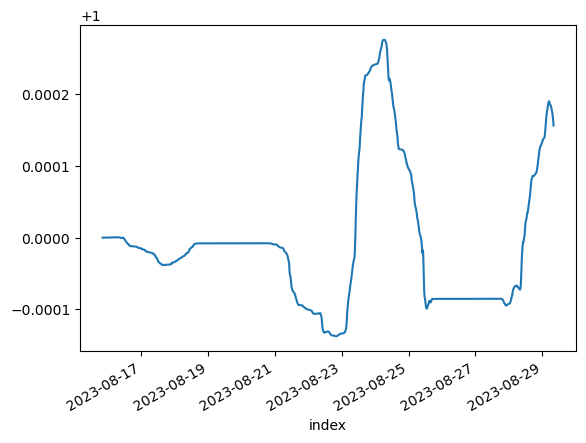

In [6]:
df['ewm_ratio'].plot()

In [161]:
long_lag

,ewm_ratio
index,
2023-08-09 18:28:00,False
2023-08-09 19:42:00,False
2023-08-09 20:01:00,False
2023-08-09 20:23:00,False
2023-08-09 20:24:00,False
...,...
2023-08-23 13:54:00,True
2023-08-23 13:58:00,True
2023-08-23 14:00:00,True


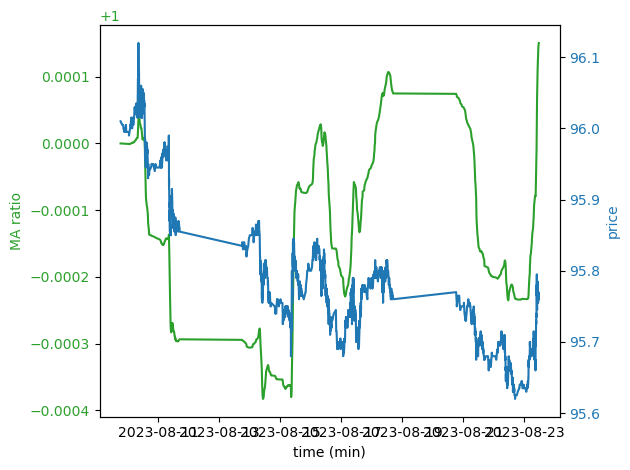

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('time (min)')
ax1.set_ylabel('MA ratio', color=color)
ax1.plot(df['ewm_ratio'].index, df['ewm_ratio'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('price', color=color)  # we already handled the x-label with ax1
ax2.plot(df['ewm_ratio'].index, df['close'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

<AxesSubplot:>

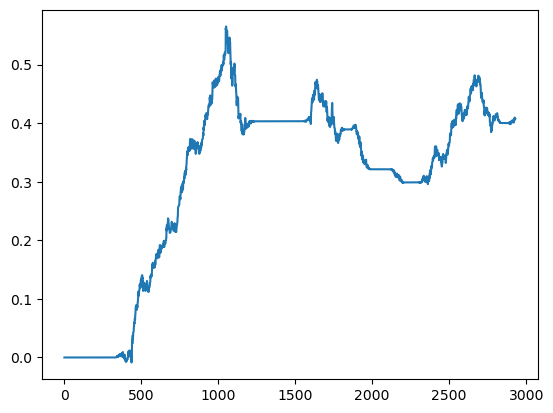

In [154]:

for h in range(holdtime-1): # this prevents doubling down of signal 
    #(but will keep extending 1 bar if the signal remains strong) so no hard take profit!
    #moving stop loss ?
    long_lag=longs.shift(h).fillna(False)
    short_lag=shorts.shift(h).fillna(False)
    pos[long_lag]=pos[long_lag]+1
    pos[short_lag]=pos[short_lag]-1
    
pos=pd.DataFrame(pos)
pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
#print(np.mean(ret))
#print(np.std(ret))
cumret=(np.cumprod(1+ret)-1)
#print("---returns data %s seconds ---" % (time.time() - start_time))
#start_time = time.time()
sharpe = np.sqrt(252)*np.mean(ret)/np.std(ret)
pos=pd.DataFrame(pos)
pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pd.Series(pnl)#/np.sum(np.abs(pos.shift()), axis=1)
cumret=(np.cumprod(1+ret)-1)
cumret.plot()#marker='x')


In [169]:
pnl#.cumsum()

array([        nan,  0.        ,  0.        , ..., -0.00202855,
        0.00027257,  0.00027631])

<AxesSubplot:>

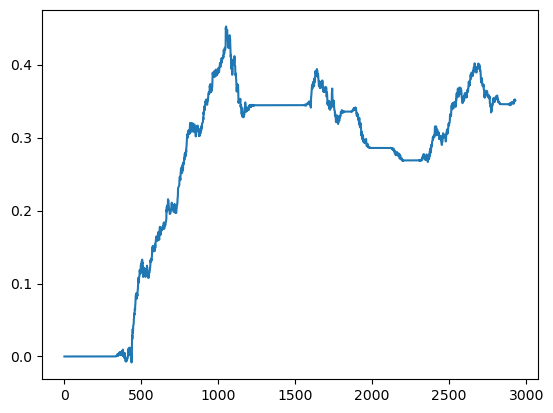

In [171]:
ret.cumsum().plot()

<AxesSubplot:>

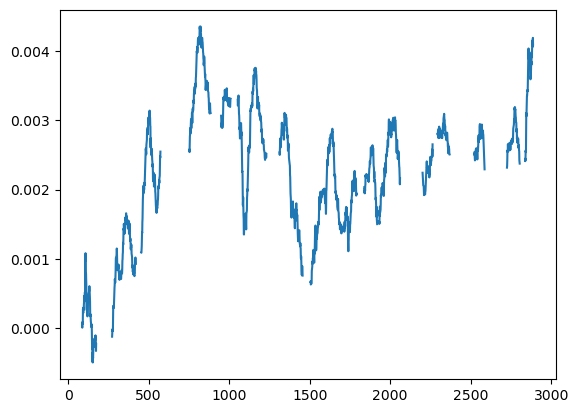

In [32]:
ma_tuples = (30,60)
holdtime=60

ratio = 0.0001

df = volume_trades[['close']].copy()

df['ewm_short'] = df['close'].ewm(span = ma_tuples[0]).mean()
df['ewm_long'] = df['close'].ewm(span = ma_tuples[1]).mean()
df['ewm_ratio'] = df['ewm_short'] /df['ewm_long'] 
        
longs= df[['ewm_ratio']] > (1+ ratio)
shorts=df[['ewm_ratio']] < (1-ratio)

pos=np.zeros(df[['close']].shape)

for h in range(holdtime-1): # this prevents doubling down of signal 
    #(but will keep extending 1 bar if the signal remains strong) so no hard take profit!
    #moving stop loss ?
    long_lag=longs.shift(h).fillna(False)
    short_lag=shorts.shift(h).fillna(False)
    pos[long_lag]=pos[long_lag]+1
    pos[short_lag]=pos[short_lag]-1
    
pos=pd.DataFrame(pos)
#pos.plot()
pos[pos[0]>1] = 1
pos[pos[0]<-1] = -1
pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
#print(np.mean(ret))
#print(np.std(ret))
cumret=(np.cumprod(1+ret)-1)
#print("---returns data %s seconds ---" % (time.time() - start_time))
#start_time = time.time()
sharpe = np.sqrt(252)*np.mean(ret)/np.std(ret)
pos=pd.DataFrame(pos)
pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
cumret=(np.cumprod(1+ret)-1)
cumret.plot()#marker='x')

In [26]:
ret

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
2883    0.000020
2884    0.000078
2885   -0.000094
2886    0.000127
2887   -0.000096
Length: 2888, dtype: float64

In [42]:
#FOR TY FUTURES
import time
df_results =pd.DataFrame()
lookback_results = []
holdday_results = []
cc_results = []
pval_results =[]
lookback_list = []
holdtime_list = []
time_space_list =[]
ratio_entry_list = []
long_time_space_list = []
short_long_tuples_list = []
trade_long_list = []
trade_short_list =[]
mean_return_list = []
#results lists
results_tuple_list = []
results_hold_list = []
results_ratio_trigger_list = []
sharpe_list = []
apr_list = []
dd_list = []
dd_time_list = []
for p in range(60,1441,60): #maybe reduce to 1 hour blocks
    time_space_list.append(p)    
#lookback long MA
for p in range(480,4320+1,480):#1440 maybe i should atleast put 4 hours between....
    long_time_space_list.append(p)   
#create tuples of lookback long MA and short MA
for i in long_time_space_list:
    for j in time_space_list:
        if j< i:
            short_long_tuples_list.append((j,i))
#entry criteria for short MA/long MA ratio:

for p in range(1,5,1):
    #1.0005
    ratio_entry_list.append(p/10000)
    
#different holdtimes
for p in range(60,601,60):
    holdtime_list.append(p)    
holdtime_list    
for p in range(60,1441,60): #maybe reduce to 1 hour blocks
    time_space_list.append(p)    
#lookback long MA
for p in range(480,4320+1,480):#1440 maybe i should atleast put 4 hours between....
    long_time_space_list.append(p)   
#create tuples of lookback long MA and short MA
for i in long_time_space_list:
    for j in time_space_list:
        if j< i:
            short_long_tuples_list.append((j,i))
#entry criteria for short MA/long MA ratio:

In [43]:
short_long_tuples_list

[(60, 480),
 (120, 480),
 (180, 480),
 (240, 480),
 (300, 480),
 (360, 480),
 (420, 480),
 (60, 960),
 (120, 960),
 (180, 960),
 (240, 960),
 (300, 960),
 (360, 960),
 (420, 960),
 (480, 960),
 (540, 960),
 (600, 960),
 (660, 960),
 (720, 960),
 (780, 960),
 (840, 960),
 (900, 960),
 (60, 1440),
 (120, 1440),
 (180, 1440),
 (240, 1440),
 (300, 1440),
 (360, 1440),
 (420, 1440),
 (480, 1440),
 (540, 1440),
 (600, 1440),
 (660, 1440),
 (720, 1440),
 (780, 1440),
 (840, 1440),
 (900, 1440),
 (960, 1440),
 (1020, 1440),
 (1080, 1440),
 (1140, 1440),
 (1200, 1440),
 (1260, 1440),
 (1320, 1440),
 (1380, 1440),
 (60, 1920),
 (120, 1920),
 (180, 1920),
 (240, 1920),
 (300, 1920),
 (360, 1920),
 (420, 1920),
 (480, 1920),
 (540, 1920),
 (600, 1920),
 (660, 1920),
 (720, 1920),
 (780, 1920),
 (840, 1920),
 (900, 1920),
 (960, 1920),
 (1020, 1920),
 (1080, 1920),
 (1140, 1920),
 (1200, 1920),
 (1260, 1920),
 (1320, 1920),
 (1380, 1920),
 (1440, 1920),
 (60, 2400),
 (120, 2400),
 (180, 2400),
 (24